In [1]:
import math
import time
import pickle
import pandas as pd
import numpy as np

In [2]:
import torch
import sklearn

In [3]:
from pyqpanda import *

In [4]:
%matplotlib inline

# 1. Prepare Dadaset

In [5]:
# https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data

In [6]:
train_path = './../data/DailyDelhiClimateTrain.csv'
test_path = './../data/DailyDelhiClimateTest.csv'

In [7]:
cols = [1,2,3,4]

train = pd.read_csv(train_path, usecols=cols, engine="python")
test = pd.read_csv(test_path, usecols=cols, engine="python")

In [8]:
print(f'len(train)={len(train)}')
print(f'len(test)={len(test)}')

len(train)=1462
len(test)=114


## 1.1 Outlier Detection

### 1.1.1 outlier detection for train

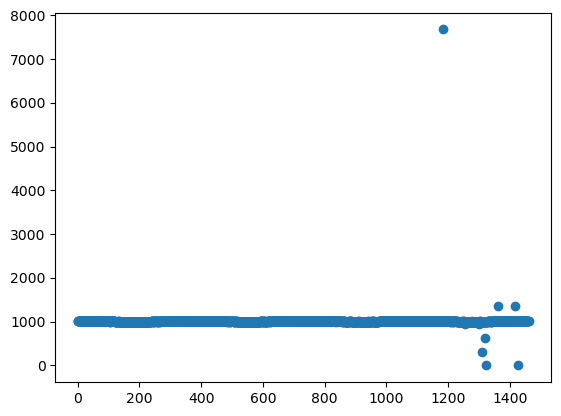

In [9]:
plt.scatter(range(len(train)), train["meanpressure"])

### - remove outliers 

In [10]:
unnormal_num = 0
for i in range(len(train)):
    mp = train.iloc[i][3]
    if mp > 1200 or mp < 950:
        unnormal_num += 1
        train.iloc[i][3] = train.iloc[i + 1][3]
print(f'remove outliers num: {unnormal_num}')

remove outliers num: 9


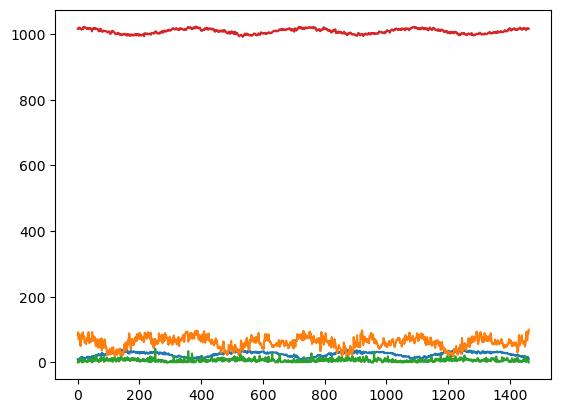

In [11]:
plt.plot(train)

In [12]:
train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
meantemp,1462.0,25.495521,7.348103,6.000000,18.857143,27.714286,31.305804,38.714286
humidity,1462.0,60.771702,16.769652,13.428571,50.375000,62.625000,72.218750,100.000000
wind_speed,1462.0,6.802209,4.561602,0.000000,3.475000,6.221667,9.238235,42.220000
meanpressure,1462.0,1008.247674,7.437992,991.375000,1001.625000,1008.563492,1014.875000,1023.000000


In [13]:
train[0:1]

,meantemp,humidity,wind_speed,meanpressure
0,10.0,84.5,0.0,1015.666667


### 1.1.2 outlier detection for test

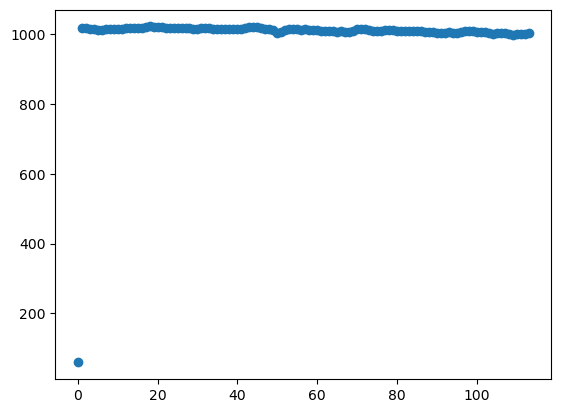

In [14]:
plt.scatter(range(len(test)), test["meanpressure"])

### - remove outliers 

In [15]:
test.iloc[0][3] = test.iloc[1][3]

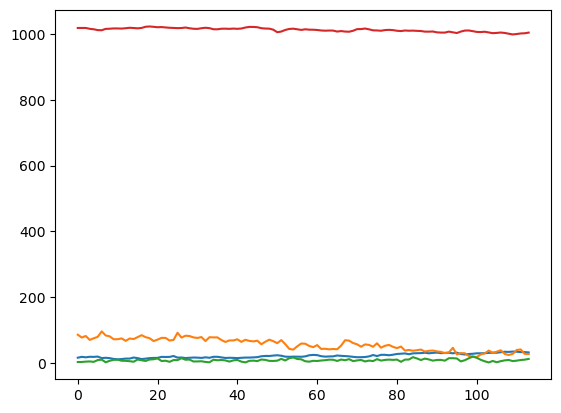

In [16]:
plt.plot(test)

## 1.2 Transfer data to LSTM representation

In [17]:
from sklearn.preprocessing import StandardScaler

In [18]:
def data_process(data, window_size, predict_size):
    scaler = StandardScaler()
    data = scaler.fit_transform(np.array(data).reshape(-1, 1))
    
    data_in = []
    data_out = []
    
    for i in range(data.shape[0] - window_size - predict_size):
        data_in.append(data[i:i + window_size].reshape(1, window_size)[0])
        data_out.append(data[i + window_size:i + window_size + predict_size].reshape(1, predict_size)[0])
        
    data_in = np.array(data_in).reshape(-1, window_size)
    data_out = np.array(data_out).reshape(-1, predict_size)
    
    data_process = {'datain': data_in, 'dataout': data_out}
    
    return data_process, scaler

## 1.3 prepare train/test dataset

In [19]:
features_size = 4
window_size = features_size * 3 # features num * time steps
predict_size = features_size # features

In [20]:
train_processed, train_scaler = data_process(train, window_size, predict_size)
X_train, y_train = train_processed['datain'], train_processed['dataout']

test_processed, test_scaler = data_process(test, window_size, predict_size)
X_test, y_test = test_processed['datain'], test_processed['dataout']

In [21]:
X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))

y_train = torch.from_numpy(y_train.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

### - data loader

In [22]:
import torch.utils.data as Data

train_data = Data.TensorDataset(X_train, y_train)
test_data = Data.TensorDataset(X_test, y_test)

In [23]:
print(f'size of train_data: {len(train_data)}')
print(f'size of test_data: {len(test_data)}')

size of train_data: 5832
size of test_data: 440


In [24]:
train_data[0]

(tensor([-0.6262, -0.4504, -0.6498,  1.7473, -0.6323, -0.4327, -0.6428,  1.7523,
         -0.6329, -0.4445, -0.6389,  1.7543]),
 tensor([-0.6293, -0.4814, -0.6469,  1.7508]))

In [25]:
test_data[0]

(tensor([-0.6067, -0.4426, -0.6376,  1.7437, -0.6006, -0.4629, -0.6372,  1.7437,
         -0.6039, -0.4520, -0.6346,  1.7438]),
 tensor([-0.6001, -0.4797, -0.6333,  1.7377]))

# 2. Quantum Enhanced LSTM

## 2.1 initiate quantum environment

In [26]:
class InitQMachine:
    def __init__(self, qubitsCount, cbitsCount = 0, machineType = QMachineType.CPU):
        self.machine = init_quantum_machine(machineType)
        
        self.qubits = self.machine.qAlloc_many(qubitsCount)
        self.cbits = self.machine.cAlloc_many(cbitsCount)
        
        print(f'Init Quantum Machine with qubits:[{qubitsCount}] / cbits:[{cbitsCount}] Successfully')
    
    def __del__(self):
        destroy_quantum_machine(self.machine)

In [27]:
# maximum qubits size
ctx = InitQMachine(5)

Init Quantum Machine with qubits:[5] / cbits:[0] Successfully


## 2.2 Quantum Layer

### - Tool Functions

In [28]:
def draw(prog, filename=''):
    dir_path = './images/'
    
    if filename != '':
        draw_qprog(prog, 'pic', filename=f'{dir_path}{filename}')

### 2.2.1 Quantum Layer Base

In [29]:
import torch.nn as nn
from torch import Tensor
from torch.nn import Parameter

In [30]:
class QuantumLayerBase(nn.Module):
    def __init__(self, input_size, output_size, *, n_qubits, n_layers = 1, ctx = None):
        super(QuantumLayerBase, self).__init__()
        
        self.data = None # need to input during forward
    
        self.input_size = input_size
        self.output_size = output_size # hidden size, not n_qubits
        
        # quantum infos
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        
        self.ctx = ctx
        self.qubits = ctx.qubits
        self.machine = ctx.machine
        
        # convert quantum input/output to match classical computation
        self.qin = nn.Linear(self.input_size, self.n_qubits)
        self.qout = nn.Linear(self.n_qubits, self.output_size)
        
    @property
    def circuit(self):
        raise NotImplementedError('Should init circuit')

In [31]:
def measure(self):
    HamiZ = [ PauliOperator({f'Z{i}': 1}) for i in range(len(self.qubits)) ]
    res = [ eval(qop(self.circuit, Hami, self.machine, self.qubits))[0,0] for Hami in HamiZ ]
    
    return Parameter(Tensor(res[:self.n_qubits]))

QuantumLayerBase.measure = measure

In [32]:
def forward(self, inputs):
    y_t = self.qin(Parameter(inputs))
    self.data = y_t[0]
    
    return self.qout(self.measure())

QuantumLayerBase.forward = forward

### 2.2.2 Quantum Layer Design

In [33]:
dropout_lock = True

In [34]:
class QuantumLayer(QuantumLayerBase):
    def __init__(self, input_size, output_size, *, n_qubits, degree = 1, n_layers = 1, ctx = None, dropout_rate = 0):
        super(QuantumLayer, self).__init__(input_size, output_size, 
                                         n_qubits = n_qubits, n_layers = n_layers, ctx = ctx)
        
        self.degree = degree
        self.dropout_rate = dropout_rate
        self.angles = Parameter(torch.rand(n_layers + 1, degree, self.n_qubits))
        
    @property
    def qparameters_size(self):
        return self.angles.flatten().size()[0]
        
    @property
    def circuit(self):
        if self.data == None:
            raise ValueError('Need to feed a input data!')
        
        n = self.n_qubits
        q = self.qubits
        x = self.data
        p = self.angles
        degree = self.degree
        
        # quantum gates - must use small case!
        identity = VariationalQuantumGate_I
        h = VariationalQuantumGate_H
        YGate = VariationalQuantumGate_Y
        ry = VariationalQuantumGate_RY
        cz = VariationalQuantumGate_CZ
        u = [
            None,
            VariationalQuantumGate_U1,
            VariationalQuantumGate_U2,
            VariationalQuantumGate_U3
        ]
        
        # init variational quantum circuit
        vqc = VariationalQuantumCircuit()

        # in order to use each qubits => when n_qubits < len(ctx.qubits)
        [ vqc.insert(identity(q[i])) for i in range(len(q)) ]
        
        [ vqc.insert( h(q[i]) ) for i in range(n) ]
        [ vqc.insert( ry(q[i], var(x[i] * torch.pi / 2)) ) for i in range(n) ]
        
    
        for i in range(n):
            vqc.insert( u[degree](q[i], *[ var(p[0][d][i]) for d in range(degree) ]) )
            if dropout_lock and np.random.rand() <= self.dropout_rate:
                vqc.insert( YGate(q[i]) )
        
        for layer in range(self.n_layers):
            for i in range(n - 1):
                vqc.insert(cz(q[i], q[i + 1]))
            vqc.insert(cz(q[n - 1], q[0]))
            
            for i in range(n):
                vqc.insert( u[degree](q[i], *[ var(p[layer + 1][d][i]) for d in range(degree) ]) )
                if dropout_lock and np.random.rand() <= self.dropout_rate:
                    vqc.insert( YGate(q[i]) )
        
        return vqc

### 2.2.3 Plot Quantum layer

In [35]:
data = Tensor([[0.1, 0.2, 0.3, 0.4, 0.5]])
layer = QuantumLayer(5, 5, n_qubits=5, n_layers=1, degree=3, dropout_rate=0.3, ctx=ctx)
layer.data = data[0]
vqc = layer.circuit
prog = create_empty_qprog()
prog.insert(vqc.feed())

In [36]:
draw_qprog(prog, 'pic', filename=f'pic/bit_phase_flip_yes')

'null'

## 2.3 Quantum-LSTM

In [37]:
class QLSTMBase(nn.Module):
    def __init__(self, input_size, hidden_size, *, ctx, dropout_rate=0):
        super().__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.ctx = ctx
        self.dropout_rate = dropout_rate
        
    @property
    def qparameters_size(self):
        num = 0
        for attr in dir(self):
            if attr.endswith('_circuit'):
                num += getattr(self, attr).qparameters_size
        return num

In [38]:
def forward(self, inputs, init_states = None):
    sequence_size, batch_size, _ = inputs.size()
    hidden_sequence = []
    
    if init_states == None:
        h_t, c_t = (
            torch.zeros(1, batch_size, self.hidden_size).to(inputs.device),
            torch.zeros(1, batch_size, self.hidden_size).to(inputs.device),
        )
    else:
        h_t, c_t = init_states
    
    return hidden_sequence, (h_t, c_t)

QLSTMBase.forward = forward

### 2.3.1 classical Quantum-LSTM

In [39]:
class QLSTM(QLSTMBase):
    def __init__(self, input_size, hidden_size, *, ctx, dropout_rate=0):
        super().__init__(input_size, hidden_size, ctx = ctx, dropout_rate = dropout_rate)
        
        # Parameters: angles
        #  => Q * (n + 1) * degree
        
        # gates names:  qubits  layers  degree
        # input gate:     5       2       3
        # forget gate:    5       2       3
        # candidate:      5       2       3
        # output gate:    5       2       3
        
        # input gates
        self.input_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                        n_qubits = 5, n_layers = 2, degree = 3, ctx = ctx, dropout_rate = dropout_rate) # 45
        # forget gates
        self.forget_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                         n_qubits = 5, n_layers = 2, degree = 3, ctx = ctx, dropout_rate = dropout_rate) # 45
        # candidate
        self.candidate_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                       n_qubits = 5, n_layers = 2, degree = 3, ctx = ctx, dropout_rate = dropout_rate) # 45
        # output gates
        self.output_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                         n_qubits = 5, n_layers = 2, degree = 3, ctx = ctx, dropout_rate = dropout_rate) # 45
        
    def forward(self, inputs, init_states = None):
        hidden_sequence, (h_t, c_t) = super(QLSTM, self).forward(inputs, init_states)

        for t in range(inputs.size()[0]):
            x_t = inputs[t, :, :]
            v_t = torch.cat((h_t[0], x_t), dim = 1)

            # input gates
            i_t = torch.sigmoid(self.input_circuit(v_t))
            # forget gates
            f_t = torch.sigmoid(self.forget_circuit(v_t))
            # candidate for cell state update
            g_t = torch.tanh(self.candidate_circuit(v_t))
            c_t = (f_t * c_t) + (i_t * g_t)

            # output gates
            o_t = torch.sigmoid(self.output_circuit(v_t))
            # update output ht
            h_t = o_t * (torch.tanh(c_t))

            hidden_sequence.append(h_t)

        # reshape hidden_seq p/ retornar
        #
        # [tensor([[[0.0444, ...]]] => tensor([[[0.0444, ...]]]
        # 
        hidden_sequence = torch.cat(hidden_sequence, dim = 0)

        return hidden_sequence, (h_t, c_t)

### 2.3.2 adjusted classical QLSTM

In [40]:
class AdjustedQLSTM(QLSTMBase):
    def __init__(self, input_size, hidden_size, *, ctx, dropout_rate = 0):
        super().__init__(input_size, hidden_size, ctx = ctx, dropout_rate = dropout_rate)
        
        # gates names:  qubits  layers  degree
        # input gate:     4       2       3
        # forget gate:    5       2       3
        # candidate:      4       1       3
        # output gate:    3       2       2
        
        # input gates
        self.input_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                        n_qubits = 4, n_layers = 2, degree = 3, ctx = ctx, dropout_rate = dropout_rate) # 36
        # forget gates
        self.forget_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                         n_qubits = 5, n_layers = 2, degree = 3, ctx = ctx, dropout_rate = dropout_rate) # 45
        # candidate
        self.candidate_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                       n_qubits = 4, n_layers = 1, degree = 3, ctx = ctx, dropout_rate = dropout_rate) # 24
        # output gates
        self.output_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                         n_qubits = 3, n_layers = 2, degree = 2, ctx = ctx, dropout_rate = dropout_rate) # 18
        
    def forward(self, inputs, init_states = None):
        hidden_sequence, (h_t, c_t) = super(AdjustedQLSTM, self).forward(inputs, init_states)

        for t in range(inputs.size()[0]):
            x_t = inputs[t, :, :]
            v_t = torch.cat((h_t[0], x_t), dim = 1)

            # input gates
            i_t = torch.sigmoid(self.input_circuit(v_t))
            # forget gates
            f_t = torch.sigmoid(self.forget_circuit(v_t))
            # candidate for cell state update
            g_t = torch.tanh(self.candidate_circuit(v_t))
            c_t = (f_t * c_t) + (i_t * g_t)

            # output gates
            o_t = torch.sigmoid(self.output_circuit(v_t))
            # update output ht
            h_t = o_t * (torch.tanh(c_t))

            hidden_sequence.append(h_t)

        hidden_sequence = torch.cat(hidden_sequence, dim = 0)

        return hidden_sequence, (h_t, c_t)

### 2.3.3 peephole QLSTM

In [41]:
class PeepholeQLSTM(QLSTMBase):
    def __init__(self, input_size, hidden_size, *, ctx, dropout_rate = 0):
        super().__init__(input_size, hidden_size, ctx = ctx, dropout_rate = dropout_rate)
        
        # gates names:  qubits  layers  degree
        # input gate:     4       2       3
        # forget gate:    5       2       3
        # candidate:      4       1       3
        # output gate:    3       2       2
        
        # input gates
        self.input_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                        n_qubits = 4, n_layers = 2, degree = 3, ctx = ctx, dropout_rate = dropout_rate) # 36
        # forget gates
        self.forget_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                         n_qubits = 5, n_layers = 2, degree = 3, ctx = ctx, dropout_rate = dropout_rate) # 45
        # candidate
        self.candidate_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                       n_qubits = 4, n_layers = 1, degree = 3, ctx = ctx, dropout_rate = dropout_rate) # 24
        # output gates
        self.output_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                         n_qubits = 3, n_layers = 2, degree = 2, ctx = ctx, dropout_rate = dropout_rate) # 18
        
    def forward(self, inputs, init_states = None):
        hidden_sequence, (h_t, c_t) = super(PeepholeQLSTM, self).forward(inputs, init_states)

        for t in range(inputs.size()[0]):
            x_t = inputs[t, :, :]
            v_t = torch.cat((c_t[0], x_t), dim = 1)
            
            # input gates
            i_t = torch.sigmoid(self.input_circuit(v_t))
            # forget gates
            f_t = torch.sigmoid(self.forget_circuit(v_t))
            # candidate for cell state update
            g_t = torch.tanh(self.candidate_circuit(v_t))
            c_t = (f_t * c_t) + (i_t * g_t)
            
            # output gates
            o_t = torch.sigmoid(self.output_circuit(v_t))
            # update output ht
            h_t = o_t * (torch.tanh(c_t))

            hidden_sequence.append(h_t)

        hidden_sequence = torch.cat(hidden_sequence, dim = 0)

        return hidden_sequence, (h_t, c_t)

### 2.3.4 Coupled Input and Forget gates QLSTM

In [42]:
class CIFGQLSTM(QLSTMBase):
    def __init__(self, input_size, hidden_size, *, ctx, dropout_rate = 0):
        super().__init__(input_size, hidden_size, ctx = ctx, dropout_rate = dropout_rate)
        
        # gates names:  qubits  layers  degree
        # coupled IF:     5       2       3
        # candidate:      4       2       3
        # output gate:    3       2       2
        
        # Coupled Input and Forget gate
        self.coupled_IF_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                         n_qubits = 5, n_layers = 2, degree = 3, ctx = ctx, dropout_rate = dropout_rate) # 30
        # candidate for cell state update
        self.candidate_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                       n_qubits = 4, n_layers = 2, degree = 3, ctx = ctx, dropout_rate = dropout_rate) # 24
        # output gates
        self.output_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                         n_qubits = 3, n_layers = 2, degree = 2, ctx = ctx, dropout_rate = dropout_rate) # 12
        
    def forward(self, inputs, init_states = None):
        hidden_sequence, (h_t, c_t) = super(CIFGQLSTM, self).forward(inputs, init_states)

        for t in range(inputs.size()[0]):
            x_t = inputs[t, :, :]
            v_t = torch.cat((h_t[0], x_t), dim = 1)
            
            # coupled input and forget gate
            f_t = torch.sigmoid(self.coupled_IF_circuit(v_t))
            # candidate for cell state update
            g_t = torch.tanh(self.candidate_circuit(v_t))
            c_t = (f_t * c_t) + ((1 - f_t) * g_t)
            
            # output gates
            o_t = torch.sigmoid(self.output_circuit(v_t))
            # update output ht
            h_t = o_t * (torch.tanh(c_t))

            hidden_sequence.append(h_t)

        hidden_sequence = torch.cat(hidden_sequence, dim = 0)

        return hidden_sequence, (h_t, c_t)

### 2.3.5 Recurrent Gate Units - QGRU

In [43]:
class QGRU(QLSTMBase):
    def __init__(self, input_size, hidden_size, *, ctx, dropout_rate = 0):
        super().__init__(input_size, hidden_size, ctx = ctx, dropout_rate = dropout_rate)
        
        # gates names:  qubits  layers  degree
        # update gate:     5       1       3
        # candidate:       4       1       3
        # reset gate:      3       1       2
        
        # update gates
        self.update_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                         n_qubits = 5, n_layers = 1, degree = 3, ctx = ctx, dropout_rate = dropout_rate) # 45
        # candidate for hidden state update
        self.candidate_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                       n_qubits = 4, n_layers = 1, degree = 3, ctx = ctx, dropout_rate = dropout_rate) # 36
        # reset gates
        self.reset_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                         n_qubits = 3, n_layers = 1, degree = 2, ctx = ctx, dropout_rate = dropout_rate) # 18
        
    def forward(self, inputs, init_states = None):
        hidden_sequence, (h_t, c_t) = super(QGRU, self).forward(inputs, init_states)

        for t in range(inputs.size()[0]):
            x_t = inputs[t, :, :]
            v_t = torch.cat((h_t[0], x_t), dim = 1)
            
            # update gates
            z_t = torch.sigmoid(self.update_circuit(v_t))
            # reset gates
            r_t = torch.sigmoid(self.reset_circuit(v_t))
        
            v_hat_t = torch.cat(((r_t * h_t)[0], x_t), dim = 1)
            # candidate for hidden state update
            g_t = torch.tanh(self.candidate_circuit(v_hat_t))
            h_t = (z_t * g_t) + (1 - z_t) * h_t 

            hidden_sequence.append(h_t)

        hidden_sequence = torch.cat(hidden_sequence, dim = 0)

        return hidden_sequence, (h_t, c_t)

### - QLSTMs Map

In [44]:
QLSTMMap = {
    'classical': ('QLSTM', QLSTM),
    'adjusted': ('QLSTM(adjusted)', AdjustedQLSTM),
    'peephole': ('peephole QLSTM', PeepholeQLSTM),
    'CIFG': ('CIFG-QLSTM', CIFGQLSTM),
    'GRU': ('QGRU', QGRU)
}

## 2.4 Stacked QLSTM

In [45]:
from collections import OrderedDict

class StackedQLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, *, num_layers = 1, ctx = None, mode = 'classical', dropout_rate = 0):
        super().__init__()
        
        label, qlstm = QLSTMMap.get(mode)
        self.qlstms = nn.Sequential(OrderedDict([
            (f'{label} {i + 1}', qlstm(input_size if i == 0 else hidden_size , hidden_size, ctx = ctx, dropout_rate = dropout_rate)) 
                for i in range(num_layers)
        ]))

    def forward(self, inputs, parameters = None):
        outputs = None
        
        for i, qlstm in enumerate(self.qlstms):
            if i != 0:
                inputs = outputs
            
            outputs, parameters = qlstm(inputs, parameters)
        
        return outputs, parameters

# 3. Quantum Model and Train

In [46]:
class QModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_output, *, num_layers = 1, ctx = None, mode = 'classical', dropout_rate = 0):
        super(QModel, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.mode = mode
        
        self.qlstm = StackedQLSTM(input_size, hidden_size, 
                                  num_layers = num_layers, ctx = ctx, mode = mode, dropout_rate = dropout_rate)
        self.predict = nn.Linear(hidden_size, num_output)

    def forward(self, x):
        x = x.unsqueeze(0)
        
        # sequence lenth , batch_size, features length
        # 
        h0 = torch.zeros(1, x.size(1), self.hidden_size)
        c0 = torch.zeros(1, x.size(1), self.hidden_size)
        
        out, _ = self.qlstm(x, (h0, c0))
        out = self.predict(out[0])
        
        return out

## 3.1 train QModel

In [49]:
from torch.utils.data import RandomSampler

def train_model(model, datas, batch_size, *, loss_func, optimizer, epoch = 50, early_stop = False):
    losses = []
    sampler = RandomSampler(datas, num_samples = batch_size)
    
    last_loss = 0.0
    for step in range(epoch):
        train_loss = 0.0
        
        for index in sampler:
            batch_x, batch_y = datas[index][0], datas[index][1]
            b_x = batch_x.unsqueeze(0)
            b_y = batch_y.unsqueeze(0)
            
            output = model(b_x)

            loss = loss_func(output, b_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        loss = train_loss / batch_size
        if early_stop and loss < 0.0005:
            break
            
        last_loss = loss
        
        print(f'Epoch {step + 1}/{epoch}: Loss: {loss}')
        losses.append(loss)
    
    return losses

## 3.2 Evaluate Model

In [48]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

def MAE_naive(actuals, predicteds):
    n = len(actuals)
    err = 0.0
    
    for i in range(1, n):
        err += np.abs(actuals[i] - actuals[i - 1])
    return err / (n - 1)

def calculate_accuarcy(model, X_test, y_test, scaler=test_scaler):
    n = len(X_test)
    
    actuals = []
    predicteds = []
    
    for i in range(0, n, predict_size):
        actual = scaler.inverse_transform(y_test[i:i+1].data)
        actuals.append(np.array(actual[0]))
        predicted = scaler.inverse_transform(model(X_test[i:i+1]).data)
        predicteds.append(np.array(predicted[0]))
    
    actuals = np.array(actuals)
    predicteds = np.array(predicteds)
    
    mae = mean_absolute_error(actuals, predicteds)
    mase = mae / MAE_naive(actuals.flatten(), predicteds.flatten())
    mape = mean_absolute_percentage_error(actuals, predicteds)
    mse = mean_squared_error(actuals, predicteds)
    rmse = mse ** 0.5
    
    return np.array([(1 - mase) * 100, rmse, mse, mae, mape])

## 3.3 Train Model

In [50]:
features_size = 4
window_size = features_size * 3 # 
predict_size = features_size # features

input_size = window_size
num_output = predict_size

hidden_size = 32
num_layers = 2

In [50]:
# learning rate:
# classical: 0.0035
# adjusted: 0.0028
# peephole: 0.0027
# CIFG: 0.004
# GRU: 0.0035

In [51]:
best_score = 0
best_model = None
count = 1
for dropout_rate in [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.001, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.05]:
    print('-' * 20)
    print('count:', count)
    print('selected hidden_size: ', hidden_size)
    print('selected num_layers: ', num_layers)
    print('selected dropout_rate: ', dropout_rate)
    count += 1
    dropout_lock = True
    qmodel = QModel(input_size, hidden_size, num_output, 
        num_layers = num_layers, ctx = ctx, mode='adjusted', dropout_rate=dropout_rate)
    optimizer = torch.optim.AdamW(qmodel.parameters(), lr = 0.0028)
    loss_func = nn.MSELoss()

    losses = train_model(qmodel, train_data, batch_size=20,          
                   loss_func = loss_func, optimizer = optimizer, epoch = 100)
    dropout_lock = False
    score = calculate_accuarcy(qmodel, X_test, y_test).numpy()
    if score > best_score:
        best_score = score
        best_model = qmodel
        best_parameters = {
            'hidden_size': hidden_size,
            'num_layers': num_layers,
            'dropout_rate': dropout_rate
        }
    print()

print("Best score: ", best_score)
print("Best parameters: ", best_parameters)

--------------------
count: 1
selected hidden_size:  32
selected num_layers:  2
selected dropout_rate:  0.0001


KeyboardInterrupt: 

In [170]:
best_parameters

{'hidden_size': 32, 'num_layers': 2, 'dropout_rate': 0.0003}

In [52]:
epoch = 1
acc, rmse, mse, mae, mape = 0, 0, 0, 0, 0
for i in range(epoch):
    print(f'epoch: {i+1}')
    dropout_lock = True
    qmodel = QModel(input_size, hidden_size, num_output, 
                    num_layers = num_layers, ctx = ctx, mode='classical', dropout_rate = 0.001)
    optimizer = torch.optim.Adam(qmodel.parameters(), lr = 0.0035)
    loss_func = nn.MSELoss()

    start = time.time()
    losses = train_model(qmodel, train_data, batch_size=20,          
                   loss_func = loss_func, optimizer = optimizer, epoch = 300, early_stop=True)
    end = time.time()

    print(f'time costs: {end - start}')

    dropout_lock = False
    results = calculate_accuarcy(qmodel, X_test, y_test)
    acc += results[0]
    rmse += results[1]
    mse += results[2]
    mae += results[3]
    mape += results[4]

    print(results)

print('mean acc: ', acc / epoch)
print('mean rmse: ', rmse / epoch)
print('mean mse: ', mse / epoch)
print('mean mae: ', mae / epoch)
print('mean mape: ', mape / epoch)

epoch: 1
Epoch 1/300: Loss: 1.0250981450080872
Epoch 2/300: Loss: 0.9853397935628891
Epoch 3/300: Loss: 0.9526467382907867
Epoch 4/300: Loss: 0.9352132767438889
Epoch 5/300: Loss: 0.9028758883476258
Epoch 6/300: Loss: 0.7934762716293335
Epoch 7/300: Loss: 0.64863520860672
Epoch 8/300: Loss: 0.603095081448555
Epoch 9/300: Loss: 0.4363779164850712
Epoch 10/300: Loss: 0.4312204020097852
Epoch 11/300: Loss: 0.2551721836440265
Epoch 12/300: Loss: 0.24991775141097605
Epoch 13/300: Loss: 0.19110799618065358
Epoch 14/300: Loss: 0.23292521815747022
Epoch 15/300: Loss: 0.28536735454108564
Epoch 16/300: Loss: 0.4211656432249583
Epoch 17/300: Loss: 0.3149510751769412
Epoch 18/300: Loss: 0.3186343711509835
Epoch 19/300: Loss: 0.35016510924324395
Epoch 20/300: Loss: 0.2432519772555679
Epoch 21/300: Loss: 0.23137868449557572
Epoch 22/300: Loss: 0.21228894805535675
Epoch 23/300: Loss: 0.21132279164157808
Epoch 24/300: Loss: 0.09123682756617199
Epoch 25/300: Loss: 0.23430192905943842
Epoch 26/300: Loss

Epoch 200/300: Loss: 0.0026554673655482474
Epoch 201/300: Loss: 0.011820418408751721
Epoch 202/300: Loss: 0.0008873686529113911
Epoch 203/300: Loss: 0.0010829305563675006
Epoch 204/300: Loss: 0.0015402470457047458
Epoch 205/300: Loss: 0.0131226946861716
Epoch 206/300: Loss: 0.0016495001931616572
Epoch 207/300: Loss: 0.0844986864263774
Epoch 208/300: Loss: 0.0072780401387717575
Epoch 209/300: Loss: 0.006284631299786269
Epoch 210/300: Loss: 0.0198116866115015
Epoch 211/300: Loss: 0.0026502658423851245
Epoch 212/300: Loss: 0.006612887103983667
Epoch 213/300: Loss: 0.0017394324495398905
Epoch 214/300: Loss: 0.031089216989494163
Epoch 215/300: Loss: 0.06960931034409441
Epoch 216/300: Loss: 0.03745694005629048
Epoch 217/300: Loss: 0.005041068856371567
Epoch 218/300: Loss: 0.005413233017316088
Epoch 219/300: Loss: 0.004330943604873028
Epoch 220/300: Loss: 0.011395034688757733
Epoch 221/300: Loss: 0.0015692505212427932
Epoch 222/300: Loss: 0.0006862329981231596
Epoch 223/300: Loss: 0.000607879

In [51]:
epoch = 1
acc, rmse, mse, mae, mape = 0, 0, 0, 0, 0
for i in range(epoch):
    print(f'epoch: {i+1}')
    dropout_lock = True
    qmodel = QModel(input_size, hidden_size, num_output, 
                    num_layers = num_layers, ctx = ctx, mode='classical', dropout_rate = 0.001)
    optimizer = torch.optim.Adam(qmodel.parameters(), lr = 0.0035)
    loss_func = nn.MSELoss()

    start = time.time()
    losses = train_model(qmodel, train_data, batch_size=20,          
                   loss_func = loss_func, optimizer = optimizer, epoch = 300, early_stop=True)
    end = time.time()

    print(f'time costs: {end - start}')

    dropout_lock = False
    results = calculate_accuarcy(qmodel, X_test, y_test)
    acc += results[0]
    rmse += results[1]
    mse += results[2]
    mae += results[3]
    mape += results[4]

    print(results)

print('mean acc: ', acc / epoch)
print('mean rmse: ', rmse / epoch)
print('mean mse: ', mse / epoch)
print('mean mae: ', mae / epoch)
print('mean mape: ', mape / epoch)

epoch: 1
Epoch 1/300: Loss: 0.9780574440956116
Epoch 2/300: Loss: 0.9912856996059418
Epoch 3/300: Loss: 0.9506323218345643
Epoch 4/300: Loss: 0.9338102996349334
Epoch 5/300: Loss: 0.8924972385168075
Epoch 6/300: Loss: 0.8549325257539749
Epoch 7/300: Loss: 0.8003448426723481
Epoch 8/300: Loss: 0.7531755343079567
Epoch 9/300: Loss: 0.5759926870465278
Epoch 10/300: Loss: 0.45820150058716536
Epoch 11/300: Loss: 0.5194736396893859
Epoch 12/300: Loss: 0.4965386824216694
Epoch 13/300: Loss: 0.49230199116282164
Epoch 14/300: Loss: 0.3046871546655893
Epoch 15/300: Loss: 0.4051477211061865
Epoch 16/300: Loss: 0.2968644869979471
Epoch 17/300: Loss: 0.21434204475954174
Epoch 18/300: Loss: 0.10124012776650489
Epoch 19/300: Loss: 0.10623353325063363
Epoch 20/300: Loss: 0.13972313459962607
Epoch 21/300: Loss: 0.03308720304630697
Epoch 22/300: Loss: 0.022506290969613475
Epoch 23/300: Loss: 0.015222922166140051
Epoch 24/300: Loss: 0.006162108301941771
Epoch 25/300: Loss: 0.004486018396892178
Epoch 26/3

In [58]:
# bitphase flip: 0.0001
# mean acc:  98.15764478185861
# mean rmse:  11.876788149720786
# mean mse:  157.80795717539
# mean mae:  9.549728845085813
# mean mape:  0.38799482748210523

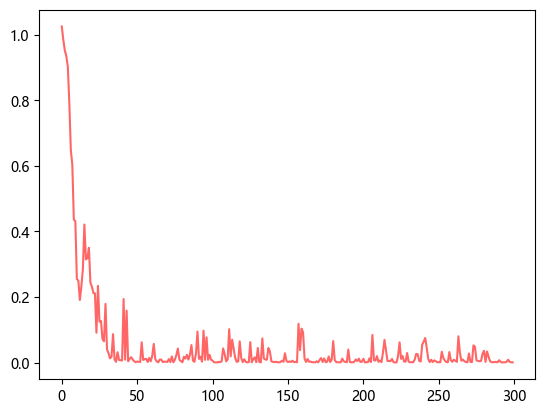

In [55]:
import matplotlib.pyplot as plt
plt.rc('font',family='Microsoft YaHei')
plt.rcParams['axes.unicode_minus'] = False

plt.plot(losses, color="#FF6666")

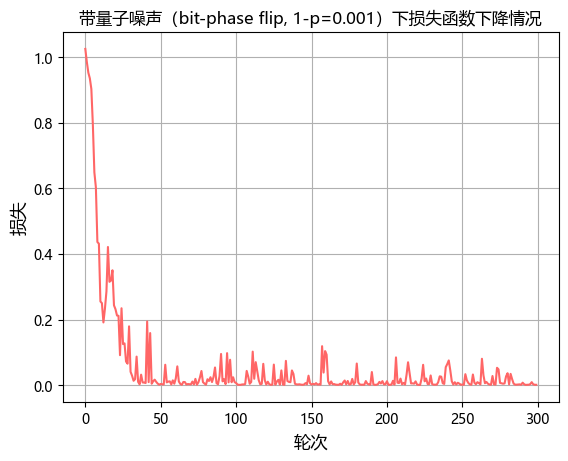

In [63]:
plt.title("带量子噪声（bit-phase flip, 1-p=0.001）下损失函数下降情况")
plt.xlabel("轮次", fontsize=12.5)
plt.ylabel("损失", fontsize=12.5)
plt.grid()
plt.plot(losses, color="#FF6666")

In [59]:
epoch = 5
acc, rmse, mse, mae, mape = 0, 0, 0, 0, 0
for i in range(epoch):
    print(f"epoch: {i + 1}")
    dropout_lock = True
    qmodel = QModel(input_size, hidden_size, num_output, 
                    num_layers = num_layers, ctx = ctx, mode='classical', dropout_rate = 0.001)
    optimizer = torch.optim.Adam(qmodel.parameters(), lr = 0.0035)
    loss_func = nn.MSELoss()

    start = time.time()
    losses = train_model(qmodel, train_data, batch_size=20,          
                   loss_func = loss_func, optimizer = optimizer, epoch = 100, early_stop=True)
    end = time.time()

    print(f'time costs: {end - start}')

    dropout_lock = False
    results = calculate_accuarcy(qmodel, X_test, y_test)
    acc += results[0]
    rmse += results[1]
    mse += results[2]
    mae += results[3]
    mape += results[4]

    print(results)

print('mean acc: ', acc / epoch)
print('mean rmse: ', rmse / epoch)
print('mean mse: ', mse / epoch)
print('mean mae: ', mae / epoch)
print('mean mape: ', mape / epoch)

epoch: 1
Epoch 1/100: Loss: 1.01621812582016
Epoch 2/100: Loss: 0.9726888716220856
Epoch 3/100: Loss: 0.9585238456726074
Epoch 4/100: Loss: 0.9336611896753311
Epoch 5/100: Loss: 0.8838653773069381
Epoch 6/100: Loss: 0.8021602988243103
Epoch 7/100: Loss: 0.7433784410357476
Epoch 8/100: Loss: 0.7024115860462189
Epoch 9/100: Loss: 0.5561951603740454
Epoch 10/100: Loss: 0.549027425237
Epoch 11/100: Loss: 0.38579808417707684
Epoch 12/100: Loss: 0.3946440835949033
Epoch 13/100: Loss: 0.3529249018989503
Epoch 14/100: Loss: 0.3135389775037766
Epoch 15/100: Loss: 0.3298674869991373
Epoch 16/100: Loss: 0.27423858490074055
Epoch 17/100: Loss: 0.1907772849081084
Epoch 18/100: Loss: 0.30224682339467107
Epoch 19/100: Loss: 0.24711910504847764
Epoch 20/100: Loss: 0.20517816240899264
Epoch 21/100: Loss: 0.13721447819843888
Epoch 22/100: Loss: 0.13634802733176912
Epoch 23/100: Loss: 0.0658978756837314
Epoch 24/100: Loss: 0.06859580263844692
Epoch 25/100: Loss: 0.08912023744778708
Epoch 26/100: Loss: 0.

Epoch 100/100: Loss: 0.018848297971999273
time costs: 922.081375837326
[ 96.4591869   21.51980121 463.10184414  18.35357518   0.94383315]
epoch: 3
Epoch 1/100: Loss: 1.0036854863166809
Epoch 2/100: Loss: 1.0212879091501237
Epoch 3/100: Loss: 0.9745456725358963
Epoch 4/100: Loss: 0.9373916327953339
Epoch 5/100: Loss: 0.8455839663743973
Epoch 6/100: Loss: 0.7837282508611679
Epoch 7/100: Loss: 0.6679483011364937
Epoch 8/100: Loss: 0.5783219173550606
Epoch 9/100: Loss: 0.43371990919113157
Epoch 10/100: Loss: 0.3027335211634636
Epoch 11/100: Loss: 0.298170930147171
Epoch 12/100: Loss: 0.22855509929358958
Epoch 13/100: Loss: 0.13148433864116668
Epoch 14/100: Loss: 0.11283894167281687
Epoch 15/100: Loss: 0.07268285282189027
Epoch 16/100: Loss: 0.03738184943504166
Epoch 17/100: Loss: 0.015454607229912654
Epoch 18/100: Loss: 0.04005370549857616
Epoch 19/100: Loss: 0.09238923771627014
Epoch 20/100: Loss: 0.012664858714560977
Epoch 21/100: Loss: 0.002669909462565556
Epoch 22/100: Loss: 0.06103872

Epoch 97/100: Loss: 0.0013490287066815654
Epoch 98/100: Loss: 0.014286045695189386
Epoch 99/100: Loss: 0.003308660743641667
Epoch 100/100: Loss: 0.004995327325741527
time costs: 975.1647825241089
[ 97.16015438  18.17414453 330.29952949  14.72015569   0.70347775]
epoch: 5
Epoch 1/100: Loss: 0.9742562741041183
Epoch 2/100: Loss: 0.9956578493118287
Epoch 3/100: Loss: 0.9360104203224182
Epoch 4/100: Loss: 0.9791715174913407
Epoch 5/100: Loss: 0.8990677505731582
Epoch 6/100: Loss: 0.8124117344617844
Epoch 7/100: Loss: 0.6092034488916397
Epoch 8/100: Loss: 0.5619580708444118
Epoch 9/100: Loss: 0.5650837481021881
Epoch 10/100: Loss: 0.4247417276725173
Epoch 11/100: Loss: 0.4795513592660427
Epoch 12/100: Loss: 0.35889325607568023
Epoch 13/100: Loss: 0.23995683407410978
Epoch 14/100: Loss: 0.21957505652680992
Epoch 15/100: Loss: 0.2479157356545329
Epoch 16/100: Loss: 0.1871251561678946
Epoch 17/100: Loss: 0.24331027488224208
Epoch 18/100: Loss: 0.12457360178232194
Epoch 19/100: Loss: 0.06538894

In [60]:
# mean acc:  97.63842422700714
# mean rmse:  14.797978395114281
# mean mse:  243.8187340298342
# mean mae:  12.241074933398034
# mean mape:  0.6077240289731745

In [61]:
epoch = 5
acc, rmse, mse, mae, mape = 0, 0, 0, 0, 0
for i in range(epoch):
    dropout_lock = True
    qmodel = QModel(input_size, hidden_size, num_output, 
                    num_layers = num_layers, ctx = ctx, mode='classical', dropout_rate = 0.01)
    optimizer = torch.optim.Adam(qmodel.parameters(), lr = 0.0035)
    loss_func = nn.MSELoss()

    start = time.time()
    losses = train_model(qmodel, train_data, batch_size=20,          
                   loss_func = loss_func, optimizer = optimizer, epoch = 100, early_stop=True)
    end = time.time()

    print(f'time costs: {end - start}')

    dropout_lock = False
    results = calculate_accuarcy(qmodel, X_test, y_test)
    acc += results[0]
    rmse += results[1]
    mse += results[2]
    mae += results[3]
    mape += results[4]

    print(results)

print('mean acc: ', acc / epoch)
print('mean rmse: ', rmse / epoch)
print('mean mse: ', mse / epoch)
print('mean mae: ', mae / epoch)
print('mean mape: ', mape / epoch)

Epoch 1/100: Loss: 1.0055130004882813
Epoch 2/100: Loss: 0.9704905688762665
Epoch 3/100: Loss: 0.9630233883857727
Epoch 4/100: Loss: 0.9203788965940476
Epoch 5/100: Loss: 0.9083323806524277
Epoch 6/100: Loss: 0.822154876589775
Epoch 7/100: Loss: 0.7959493100643158
Epoch 8/100: Loss: 0.7047089576721192
Epoch 9/100: Loss: 0.6152191966772079
Epoch 10/100: Loss: 0.5924026057124138
Epoch 11/100: Loss: 0.6963944435119629
Epoch 12/100: Loss: 0.6101985424757004
Epoch 13/100: Loss: 0.5625968322157859
Epoch 14/100: Loss: 0.5063739709556103
Epoch 15/100: Loss: 0.5272157192230225
Epoch 16/100: Loss: 0.49311244040727614
Epoch 17/100: Loss: 0.48294295743107796
Epoch 18/100: Loss: 0.40188546739518644
Epoch 19/100: Loss: 0.5286066561937333
Epoch 20/100: Loss: 0.44534354843199253
Epoch 21/100: Loss: 0.28239002972841265
Epoch 22/100: Loss: 0.25587108377367257
Epoch 23/100: Loss: 0.3491518967784941
Epoch 24/100: Loss: 0.2231654657050967
Epoch 25/100: Loss: 0.14773291517049075
Epoch 26/100: Loss: 0.084419

Epoch 3/100: Loss: 0.9405951172113418
Epoch 4/100: Loss: 0.9764581799507142
Epoch 5/100: Loss: 0.9113746702671051
Epoch 6/100: Loss: 0.8782005250453949
Epoch 7/100: Loss: 0.8342828631401062
Epoch 8/100: Loss: 0.7017955958843232
Epoch 9/100: Loss: 0.7176925703883171
Epoch 10/100: Loss: 0.6521867252886295
Epoch 11/100: Loss: 0.5601324580609799
Epoch 12/100: Loss: 0.5047030456364154
Epoch 13/100: Loss: 0.548400129377842
Epoch 14/100: Loss: 0.41079447269439695
Epoch 15/100: Loss: 0.38055125921964644
Epoch 16/100: Loss: 0.45990986451506616
Epoch 17/100: Loss: 0.2816485784947872
Epoch 18/100: Loss: 0.38884245716035365
Epoch 19/100: Loss: 0.4326167326420546
Epoch 20/100: Loss: 0.30015705302357676
Epoch 21/100: Loss: 0.21486206352710724
Epoch 22/100: Loss: 0.3754990238696337
Epoch 23/100: Loss: 0.17155730072408915
Epoch 24/100: Loss: 0.4161907346453518
Epoch 25/100: Loss: 0.20269249211996793
Epoch 26/100: Loss: 0.10366999376565218
Epoch 27/100: Loss: 0.18893156708218156
Epoch 28/100: Loss: 0.1

Epoch 4/100: Loss: 0.9056682705879211
Epoch 5/100: Loss: 0.8863035857677459
Epoch 6/100: Loss: 0.8464916229248047
Epoch 7/100: Loss: 0.7789923951029778
Epoch 8/100: Loss: 0.6857108801603318
Epoch 9/100: Loss: 0.6836940288543701
Epoch 10/100: Loss: 0.5705516543239355
Epoch 11/100: Loss: 0.5471975151449442
Epoch 12/100: Loss: 0.5924207822419703
Epoch 13/100: Loss: 0.4324499614536762
Epoch 14/100: Loss: 0.2556714216712862
Epoch 15/100: Loss: 0.2968056082725525
Epoch 16/100: Loss: 0.2731173244770616
Epoch 17/100: Loss: 0.2377430039923638
Epoch 18/100: Loss: 0.11516046669567004
Epoch 19/100: Loss: 0.1805846836650744
Epoch 20/100: Loss: 0.11030008308589459
Epoch 21/100: Loss: 0.08196521608624607
Epoch 22/100: Loss: 0.29880462056025864
Epoch 23/100: Loss: 0.09545226955087856
Epoch 24/100: Loss: 0.12264188723638654
Epoch 25/100: Loss: 0.23229479138972237
Epoch 26/100: Loss: 0.10021362585830502
Epoch 27/100: Loss: 0.029573723502107897
Epoch 28/100: Loss: 0.040769976974115704
Epoch 29/100: Loss:

In [62]:
# mean acc:  95.37499494383651
# mean rmse:  29.29120829744308
# mean mse:  1172.3251172961834
# mean mae:  23.973413899014222
# mean mape:  0.9457630412976311

In [56]:
dropout_lock = False
calculate_accuarcy(qmodel, X_test, y_test)

array([ 98.17324359,  13.62561556, 185.65739932,   9.46887345,
         0.43725422])

In [53]:
dropout_lock = False
calculate_accuarcy(qmodel, X_test, y_test)

array([98.81048233,  8.41233403, 70.76736381,  6.16578772,  0.51296343])

In [171]:
dropout_lock = False
calculate_accuarcy(best_model, X_test, y_test)

tensor(0.9821)

### - save the model

In [160]:
with open('loss/bitphaseflip/loss3.pkl', 'wb') as pkl_file:
    pickle.dump(losses, pkl_file)

In [161]:
average_accuracy = np.mean([
    0.9782, 0.9790, 0.9821, 0.9757, 0.9806
])
average_accuracy

0.97912

### - describe trained model

In [381]:
qmodel

QModel(
  (qlstm): StackedQLSTM(
    (qlstms): Sequential(
      (QGRU 1): QGRU(
        (update_circuit): QuantumLayer(
          (qin): Linear(in_features=44, out_features=5, bias=True)
          (qout): Linear(in_features=5, out_features=32, bias=True)
        )
        (candidate_circuit): QuantumLayer(
          (qin): Linear(in_features=44, out_features=4, bias=True)
          (qout): Linear(in_features=4, out_features=32, bias=True)
        )
        (reset_circuit): QuantumLayer(
          (qin): Linear(in_features=44, out_features=3, bias=True)
          (qout): Linear(in_features=3, out_features=32, bias=True)
        )
      )
      (QGRU 2): QGRU(
        (update_circuit): QuantumLayer(
          (qin): Linear(in_features=64, out_features=5, bias=True)
          (qout): Linear(in_features=5, out_features=32, bias=True)
        )
        (candidate_circuit): QuantumLayer(
          (qin): Linear(in_features=64, out_features=4, bias=True)
          (qout): Linear(in_features=

In [379]:
trainable = 0
for p in qmodel.parameters():
    if p.requires_grad:
        trainable += p.numel()
print(f'total parameters: {trainable}')

qlstm = QLSTMMap.get(qmodel.mode)[1]
print(f'quantum paramers: {qlstm(1, 1, ctx = ctx).qparameters_size}')

total parameters: 2544
quantum paramers: 66


### - Save the Model

In [173]:
# save the model
# 0.9821
torch.save(best_model.state_dict(), "model/bitphase_flip_adjusted.pt")